In [1]:
import pandas as pd
import json
import re
import numpy as np
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import string

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
pd.set_option('display.max_columns', 50)

Data preparation.

In [38]:
email_content = joblib.load('email_content.pkl')

In [39]:
exclude = set(string.punctuation)
for i in range(len(email_content)):
    email_content[i] = ''.join(ch for ch in email_content[i] if ch not in exclude)

In [9]:
def get_tokens_stems(text, stemmer = PorterStemmer()):
    
    #get tokens
    tokens = word_tokenize(text)

    stems = [stemmer.stem(token) for token in tokens]
    
    return stems

In [62]:
max_df = 0.8
min_df = 0.05
stopwords = nltk.corpus.stopwords.words('english')

Remove stop words for topic modeling.

In [63]:
vectorizer = TfidfVectorizer(
    tokenizer = get_tokens_stems,
    lowercase = False,
    stop_words = stopwords,
    ngram_range = (1, 3),
    max_df = max_df,
    min_df = min_df
)

%time tfidf_matrix = vectorizer.fit_transform(email_content)

CPU times: user 1min 14s, sys: 683 ms, total: 1min 15s
Wall time: 1min 17s


In [64]:
count_vectorizer = CountVectorizer(
    tokenizer = get_tokens_stems,
    lowercase = False,
    stop_words = stopwords,
    ngram_range = (1, 3),
    max_df = max_df,
    min_df = min_df
)

%time count_matrix = count_vectorizer.fit_transform(email_content)

CPU times: user 1min 17s, sys: 904 ms, total: 1min 17s
Wall time: 1min 19s


In [65]:
tfidf_matrix
count_matrix

<12017x278 sparse matrix of type '<class 'numpy.float64'>'
	with 346532 stored elements in Compressed Sparse Row format>

<12017x278 sparse matrix of type '<class 'numpy.int64'>'
	with 346532 stored elements in Compressed Sparse Row format>

In [66]:
count_feature_names = count_vectorizer.get_feature_names()
tfidf_feature_names = vectorizer.get_feature_names()

In [67]:
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl');
joblib.dump(count_matrix, 'count_matrix.pkl');

joblib.dump(count_feature_names, 'count_feature_names.pkl');
joblib.dump(tfidf_feature_names, 'tfidf_feature_names.pkl');

In [12]:
count_matrix = joblib.load('count_matrix.pkl')
tfidf_matrix = joblib.load('tfidf_matrix.pkl')

count_feature_names = joblib.load('count_feature_names.pkl')
tfidf_feature_names = joblib.load('tfidf_feature_names.pkl')

['count_matrix.pkl']

Choosing number of topics. Use elbow plot.

In [130]:
import scikitplot.plotters as skplt
from scikitplot import clustering_factory
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples

In [74]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        topic_words = ' '.join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
        print('Topic {}: {}'.format(topic_idx, topic_words))

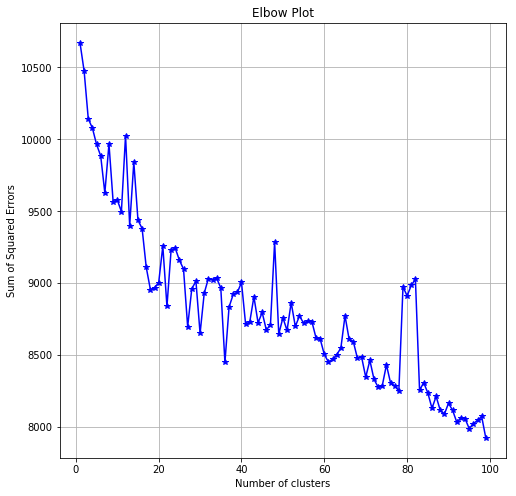

In [68]:
kmeans = clustering_factory(MiniBatchKMeans(random_state = 1))
kmeans_plot = kmeans.plot_elbow_curve(tfidf_matrix, 
                                      cluster_ranges = range(1, 100), 
                                      figsize = (8, 8))

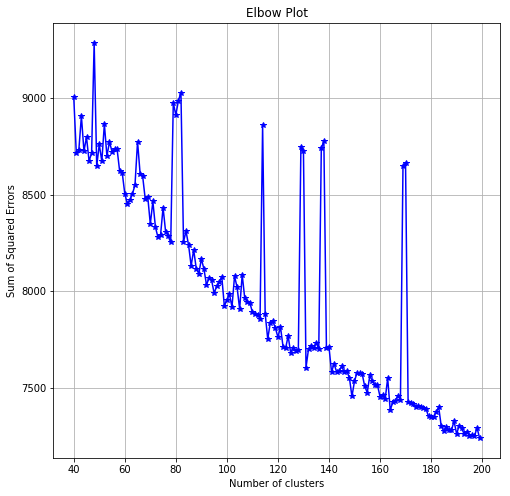

In [69]:
kmeans_plot = kmeans.plot_elbow_curve(tfidf_matrix, 
                                      cluster_ranges = range(40, 200), 
                                      figsize = (8, 8))

Try 50, 100, 150 topics.

Modeling.

In [193]:
num_topics = 50

nmf = NMF(n_components = num_topics, 
          random_state = 1, 
          alpha = 0.1, l1_ratio = 0.5, init = 'nndsvd')

#%time nmf_fit = nmf.fit(tfidf_matrix)

In [194]:
lda = LatentDirichletAllocation(n_components = num_topics, 
                                max_iter = 5, 
                                learning_method = 'online', 
                                learning_offset = 50,
                                random_state = 0)

%time lda_fit = lda.fit(count_matrix)

CPU times: user 20 s, sys: 42.4 ms, total: 20 s
Wall time: 20.1 s


In [195]:
num_top_words = 10

#display_topics(nmf_fit, tfidf_feature_names, num_top_words)
display_topics(lda_fit, count_feature_names, num_top_words)

Topic 0: chang due includ still number send continu time process howev
Topic 1: thank pleas attach bob copi find see send make regard
Topic 2: houston london new great well address hope best develop thi week
Topic 3: global busi come offic hi need around london talk interest
Topic 4: messag origin sent 2001 origin messag subject pm monday thursday wednesday
Topic 5: 1 2 3 4 5 6 10 follow first number
Topic 6: meet discuss pleas attend pleas let pleas let know plan present schedul thi
Topic 7: go eric bass cc bass cc eric bass way eric bass e time could
Topic 8: phillip k allen phillip k pleas forward cc subject ani ga
Topic 9: salli beck salli beck cc subject thank forward schedul thi note
Topic 10: 2000 per cost thi provid gener use includ month 10
Topic 11: octob let two name know use alreadi anoth 10 pleas
Topic 12: report posit file comment thi need end list ha creat
Topic 13: offic friday novemb back thursday contact regard understand sign close
Topic 14: know let let know need wa

In [196]:
doc_topic_distrib = lda_fit.transform(count_matrix)
doc_topics = np.argmax(doc_topic_distrib, axis = 1)
sil_samples = silhouette_samples(count_matrix, doc_topics)

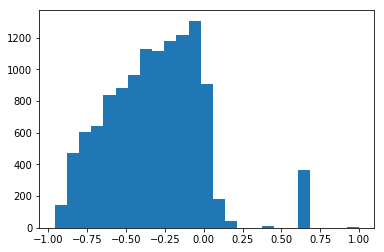

In [198]:
plt.hist(sil_samples, bins = 25);

In [85]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [92]:
pyLDAvis.prepare(**lda_fit.__dict__)

TypeError: prepare() got an unexpected keyword argument 'n_components'